In [1]:
using LinearAlgebra
using Plots
using GenericLinearAlgebra

In [2]:
using StaticArrays
using Zygote

# Standard Neo-Hookean formulation in initial configuration with Automatic Differentiation (AD) using Zygote

We consider the shear term in Neo-Hookean hyperelasticity:

\begin{align}
\phi_{\text{shear}} &= - \mu log J + \mu trace E \\
&= - \mu log (\sqrt{|I + 2 E|}) + \mu trace E 
\end{align}

\begin{equation}
S_{\text{shear}} = \partial{\phi_{\text{shear}}} / \partial{E} \\
\end{equation}

In [3]:
detCm1(E) = 8*(E[1, 1]*(E[2, 2]*E[3, 3] - E[2, 3]*E[3, 2])  +
               E[1, 2]*(E[3, 1]*E[2, 3] - E[2, 1]*E[3, 3])  +
               E[1, 3]*(E[2, 1]*E[3, 2] - E[3, 1]*E[2, 2])) +
            2*(E[1, 1] + E[2, 2] + E[3, 3]) +
            4*(E[1, 1]*E[2, 2] + E[1, 1]*E[3, 3] +
               E[2, 2]*E[3, 3] - E[1, 2]*E[2, 1] -
               E[1, 3]*E[3, 1] - E[2, 3]*E[3, 2])

psi1(E; mu=1.) = mu * (-log(det(I+2E))/2 + tr(E))
psi2(E; mu=1.)=  mu * (-log1p(detCm1(E))/2 + tr(E))

function rel_error_psi(eps, F, repr)
    ref = F(big.(eps*E)) # arbitrary precision
    norm(F(repr.(eps*E)) - ref) / norm(ref)
end

rel_error_psi (generic function with 1 method)

In [4]:
dudX = randn(3,3)
E = .5 * (dudX + dudX' + dudX' * dudX);

In [5]:
psi1(E) ≈ psi2(E)

true

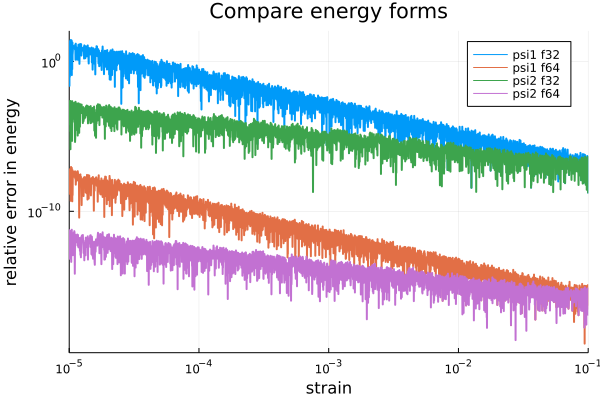

In [6]:
plot([
        e -> rel_error_psi(e, psi1, Float32),
        e -> rel_error_psi(e, psi1, Float64),
        e -> rel_error_psi(e, psi2, Float32),
        e -> rel_error_psi(e, psi2, Float64)],
    label=["psi1 f32" "psi1 f64" "psi2 f32" "psi2 f64"],
    title = "Compare energy forms",
    xlabel="strain", ylabel="relative error in energy",
    xlim=(1e-5, .1), xscale=:log10, yscale=:log10, linewidth=2)

In [7]:
function S(E, psi)
    stress, = Zygote.gradient(psi, E)
    stress
end 

S_analytical(E) = 2*inv(I + 2*E)*E

function rel_error(eps, psi, repr)
    ref = S(big.(eps*E), psi) # arbitrary precision
    norm(S(repr.(eps*E), psi) - ref) / norm(ref)
end

rel_error (generic function with 1 method)

In [8]:
S(E, psi1) ≈ S(E, psi2) ≈ S_analytical(E)

true

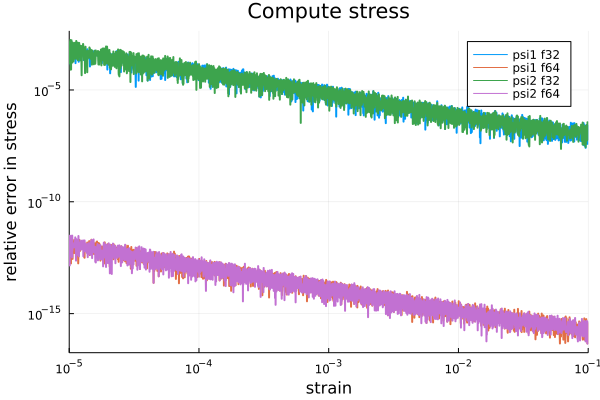

In [9]:
plot([
        e -> rel_error(e, psi1, Float32),
        e -> rel_error(e, psi1, Float64),
        e -> rel_error(e, psi2, Float32),
        e -> rel_error(e, psi2, Float64)],
    label=["psi1 f32" "psi1 f64" "psi2 f32" "psi2 f64"],
    title = "Compute stress",
    xlabel="strain", ylabel="relative error in stress",
    xlim=(1e-5, .1), xscale=:log10, yscale=:log10, linewidth=2)